In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import awkward as ak
import uproot 
import mplhep as hep
import hist
import os
import time
from numba import njit
from scipy.optimize import curve_fit
from scipy.optimize import linear_sum_assignment
import tqdm



from UtilityAndConst import *
from Functions import *

dir = "/Users/francescolarovere/Documents/Tesi-Triennale/Dati"
os.chdir(dir)

hep.style.use("CMS")
np.set_printoptions(threshold=np.inf)

In [2]:
LS133 = "./ntupleStubsBmtfGmt_LS133.root"
LS263 = "./ntupleStubsBmtfGmt_LS263.root"
LS264 = "./ntupleStubsBmtfGmt_LS264.root"
LS306 = "./ntupleStubsBmtfGmt_LS306.root"

#Open file
gmt_awk_LS133 = OpenRootFile(LS133, gmt_features)
gmt_awk_LS263 = OpenRootFile(LS263, gmt_features)
gmt_awk_LS264 = OpenRootFile(LS264, gmt_features)
gmt_awk_LS306 = OpenRootFile(LS306, gmt_features)

bmtf_awk_LS133 = OpenRootFile(LS133, bmtf_features)
bmtf_awk_LS263 = OpenRootFile(LS263, bmtf_features)
bmtf_awk_LS264 = OpenRootFile(LS264, bmtf_features)
bmtf_awk_LS306 = OpenRootFile(LS306, bmtf_features)

In [3]:
GmtEtaLS133 = gmt_awk_LS133.gmtEta
GmtEtaLS263 = gmt_awk_LS263.gmtEta
GmtEtaLS264 = gmt_awk_LS264.gmtEta
GmtEtaLS306 = gmt_awk_LS306.gmtEta

GmtPhiLS133 = gmt_awk_LS133.gmtPhi
GmtPhiLS263 = gmt_awk_LS263.gmtPhi
GmtPhiLS264 = gmt_awk_LS264.gmtPhi
GmtPhiLS306 = gmt_awk_LS306.gmtPhi

GmtPtLS133 = gmt_awk_LS133.gmtPt
GmtPtLS263 = gmt_awk_LS263.gmtPt
GmtPtLS264 = gmt_awk_LS264.gmtPt
GmtPtLS306 = gmt_awk_LS306.gmtPt


nGmtMuons_LS133 = gmt_awk_LS133.nGmtMuons
nGmtMuons_LS263 = gmt_awk_LS263.nGmtMuons
nGmtMuons_LS264 = gmt_awk_LS264.nGmtMuons
nGmtMuons_LS306 = gmt_awk_LS306.nGmtMuons


#-----------------------------------------------BMTF-----------------------------------------------

BmtfEtaLS133 = bmtf_awk_LS133.bmtfEta
BmtfEtaLS263 = bmtf_awk_LS263.bmtfEta
BmtfEtaLS264 = bmtf_awk_LS264.bmtfEta
BmtfEtaLS306 = bmtf_awk_LS306.bmtfEta

BmtfPhiLS133 = bmtf_awk_LS133.bmtfPhi
BmtfPhiLS263 = bmtf_awk_LS263.bmtfPhi
BmtfPhiLS264 = bmtf_awk_LS264.bmtfPhi
BmtfPhiLS306 = bmtf_awk_LS306.bmtfPhi

BmtfPtLS133 = bmtf_awk_LS133.bmtfPt
BmtfPtLS263 = bmtf_awk_LS263.bmtfPt
BmtfPtLS264 = bmtf_awk_LS264.bmtfPt
BmtfPtLS306 = bmtf_awk_LS306.bmtfPt


nBmtfMuons_LS133 = bmtf_awk_LS133.nBmtfMuons
nBmtfMuons_LS263 = bmtf_awk_LS263.nBmtfMuons
nBmtfMuons_LS264 = bmtf_awk_LS264.nBmtfMuons
nBmtfMuons_LS306 = bmtf_awk_LS306.nBmtfMuons

GmtEta = ak.concatenate((GmtEtaLS133, GmtEtaLS263, GmtEtaLS264, GmtEtaLS306))
BmtfEta = ak.concatenate((BmtfEtaLS133, BmtfEtaLS263, BmtfEtaLS264, BmtfEtaLS306))
GmtPhi = ak.concatenate((GmtPhiLS133, GmtPhiLS263, GmtPhiLS264, GmtPhiLS306))
BmtfPhi = ak.concatenate((BmtfPhiLS133, BmtfPhiLS263, BmtfPhiLS264, BmtfPhiLS306))
GmtPt = ak.concatenate((GmtPtLS133, GmtPtLS263, GmtPtLS264, GmtPtLS306))
BmtfPt = ak.concatenate((BmtfPtLS133, BmtfPtLS263, BmtfPtLS264, BmtfPtLS306))
nBmtfMuons = ak.concatenate((nBmtfMuons_LS133, nBmtfMuons_LS263, nBmtfMuons_LS264, nBmtfMuons_LS306))
nGmtMuons = ak.concatenate((nGmtMuons_LS133, nGmtMuons_LS263, nGmtMuons_LS264, nGmtMuons_LS306))



In [4]:
def Delta(BMTF, GMT):
  return BMTF - GMT

def DeltaR(BmtfPhi, GmtPhi, BmtfEta, GmtEta):
  return np.sqrt((BmtfPhi - GmtPhi)**2 + (BmtfEta - GmtEta)**2)

In [21]:
def CheckDuplicates(j, IndexMin, DeltaRDist, DeltaRTemp, indexTemp):
  
  IndexMin.pop(j)
  #Creo una maschera per il vecchio minimo
  Mask = np.ones(DeltaRTemp.shape, dtype=bool)
  Mask[indexTemp] = False
  Sec_minDeltaR = np.min(DeltaRTemp[Mask])
  #Trovo il nuovo minimo, applicando la maschera a DeltaRTemp
  Sec_indexTemp = np.argwhere((DeltaRTemp == Sec_minDeltaR) & Mask)[0][0]

  DeltaRDist.append(Sec_minDeltaR)
  IndexMin.append(Sec_indexTemp)

  return DeltaRDist, IndexMin

def DeltaRDist(nBmtfMuons, nGmtMuons, Bmtf_Phi, Gmt_Phi, Bmtf_Eta, Gmt_Eta, Bmtf_Pt, Gmt_Pt, Number):
  MuonsProperties = []

  for i in tqdm.tqdm(range(Number)):

    #Fare in questo modo ottimizza enormemente il processo!
    nBmtfM, nGmtM = nBmtfMuons[i], nGmtMuons[i]
    ArrBmtfPhi, ArrBmtfEta = ak.to_numpy(Bmtf_Phi[i]), ak.to_numpy(Bmtf_Eta[i])
    ArrGmtPhi, ArrGmtEta = ak.to_numpy(Gmt_Phi[i]), ak.to_numpy(Gmt_Eta[i])
    ArrBmtfPt, ArrGmtPt = ak.to_numpy(Bmtf_Pt[i]), ak.to_numpy(Gmt_Pt[i])


    DeltaRDistBMTF, DeltaRDistGMT = [], []
    IndexMinBMTF, IndexMinGMT = [], []
    PtBMTF, PtGMT = [], []

    ArrDeltaPhiBMTF, ArrDeltaEtaBMTF = [], []
    ArrDeltaPhiGMT, ArrDeltaEtaGMT = [], []


    if nGmtM == 0 and nBmtfM == 0:
      unmatched_Bmtf = []
      unmatched_Gmt = []
    
    elif nBmtfM == 0:
      unmatched_Bmtf = []
      unmatched_Gmt = [i for i in range(nGmtM)]

    elif nGmtM == 0:
      unmatched_Bmtf = [i for i in range(nBmtfM)]
      unmatched_Gmt = []


    else:
      #Primo metodo 
      for j in range(nBmtfM):

        #Calcolo il DeltaR
        DeltaRTemp = DeltaR(ArrBmtfPhi[j], ArrGmtPhi[:], ArrBmtfEta[j], ArrGmtEta[:])

        #Attento a come sono definiti IndexMin nei vari casi! Nel primo caso è confronto con tutti i muoni del GMT!
        minDeltaR = np.min(DeltaRTemp)
        indexTempGMT = np.argmin(DeltaRTemp)
        IndexMinGMT.append(indexTempGMT)

        if minDeltaR < 0.4:
          
          #Controllo che non vengano assegnati gli stessi indici dei minimi a muoni diversi
          if IndexMinGMT[j] in IndexMinGMT[:j] and nBmtfM == nGmtM:

            DeltaRDistBMTF, IndexMinGMT = CheckDuplicates(j, IndexMinGMT, DeltaRDistBMTF, DeltaRTemp, indexTempGMT)
                          

          else:
            DeltaRDistBMTF.append(minDeltaR)


          DeltaPhi_BMTF = Delta(ArrBmtfPhi[j], ArrGmtPhi[IndexMinGMT[j]])
          DeltaEta_BMTF = Delta(ArrBmtfEta[j], ArrGmtEta[IndexMinGMT[j]])
          ArrDeltaPhiBMTF.append(DeltaPhi_BMTF)
          ArrDeltaEtaBMTF.append(DeltaEta_BMTF)
          PtGMT.append(ArrGmtPt[IndexMinGMT[j]])
          
        else:
          #Se DeltaR > 0.4 (primo metodo) non c'è match con i muoni del GMT
          unmatched_Gmt = [i for i in range(nGmtM)]
    
      
        matched_Bmtf_Index = [i for i in IndexMinGMT if IndexMinGMT]
        unmatched_Bmtf = [i for i in range(nBmtfM) if i not in matched_Bmtf_Index]
        

      #Secondo metodo 
      for k in range(nGmtM):
        DeltaRTemp = DeltaR(ArrBmtfPhi[:], ArrGmtPhi[k], ArrBmtfEta[:], ArrGmtEta[k])

        minDeltaR = np.min(DeltaRTemp)
        indexTempBMTF = np.argmin(DeltaRTemp)
        IndexMinBMTF.append(indexTempBMTF)

        if minDeltaR < 0.4:
          
          if IndexMinBMTF[k] in IndexMinBMTF[:k] and nBmtfM == nGmtM:
          
            DeltaRDistGMT, IndexMinBMTF = CheckDuplicates(k, IndexMinBMTF, DeltaRDistGMT, DeltaRTemp, indexTempBMTF)
          
          else:
            DeltaRDistGMT.append(minDeltaR)

          DeltaPhi_GMT = Delta(ArrBmtfPhi[IndexMinBMTF[k]], ArrGmtPhi[k])
          DeltaEta_GMT = Delta(ArrBmtfEta[IndexMinBMTF[k]], ArrGmtEta[k])
          ArrDeltaPhiGMT.append(DeltaPhi_GMT)
          ArrDeltaEtaGMT.append(DeltaEta_GMT)
          PtBMTF.append(ArrBmtfPt[IndexMinBMTF[k]])
          
        else:
          unmatched_Bmtf = [i for i in range(nBmtfM)]

        #matched_Gmt_Index = [i for i in IndexMinBMTF if IndexMinBMTF]
        #unmatched_Gmt = [i for i in range(nGmtM) if i not in matched_Gmt_Index]


    Events = {
      'unmatched_Gmt_Events' : unmatched_Gmt,
      'unmatched_Bmtf_Events': unmatched_Bmtf, 
      'nGmtMuons': nGmtM,
      'nBmtfMuons': nBmtfM,
      'DeltaPhiBMTF': ArrDeltaPhiBMTF,
      'DeltaEtaBMTF': ArrDeltaEtaBMTF,
      'DeltaPhiGMT': ArrDeltaPhiGMT,
      'DeltaEtaGMT': ArrDeltaEtaGMT,
      #Solo i Pt che hanno fatto il match
      'PtBMTF': PtBMTF,
      'PtGMT': PtGMT, 
      # tutti i Pt
      'AllPtBMTF': ArrBmtfPt,
      'AllPtGMT': ArrGmtPt

    }

    MuonsProperties.append(Events)



  return MuonsProperties

In [22]:
MuonsProperties = DeltaRDist(nBmtfMuons, nGmtMuons, BmtfPhi, GmtPhi, BmtfEta, GmtEta, BmtfPt, GmtPt, Number = 300000)#len(nBmtfMuons))

100%|██████████| 300000/300000 [01:31<00:00, 3280.67it/s]


In [23]:
MuonsProperties = ak.Array(MuonsProperties)

In [24]:
print("# of unmatched BMTF = ", ak.sum(ak.num(MuonsProperties.unmatched_Bmtf_Events)))
print("# of unmatched GMT = ", ak.sum(ak.num(MuonsProperties.unmatched_Gmt_Events)))

Tot_Unmatched_GMT = ak.sum(ak.num(MuonsProperties.unmatched_Gmt_Events))
Tot_Unmatched_BMTF = ak.sum(ak.num(MuonsProperties.unmatched_Bmtf_Events))

Tot_Matched_GMT = ak.sum(MuonsProperties.nGmtMuons)
Tot_Matched_BMTF = ak.sum(MuonsProperties.nBmtfMuons)

fractionBMTF = Tot_Unmatched_BMTF / Tot_Matched_BMTF * 100
fractionGMT = Tot_Unmatched_GMT / Tot_Matched_GMT * 100

print(f"unmatchedGMT: {fractionGMT:.2f}, unmatchedBMTF: {fractionBMTF:.2f}")

# of unmatched BMTF =  3270
# of unmatched GMT =  142
unmatchedGMT: 0.26, unmatchedBMTF: 5.60


# Matching efficiency 

In [25]:
count = 0
for i in range(100000):
  if len(MuonsProperties.unmatched_Gmt_Events[i]) != 0:
    print(i, MuonsProperties.unmatched_Gmt_Events[i])
    count += 1
print(count)

i = 192#, 280, 360, 719, 801, 997
'''print(MuonsProperties.nBmtfMuons[i])
print(MuonsProperties.PtBMTF[i])'''

test = ak.sum(ak.flatten(MuonsProperties.unmatched_Gmt_Events[:100000]))
test2 = len(ak.flatten(MuonsProperties.unmatched_Gmt_Events[:100000]))
print(test, test2)



PtBMTF = MuonsProperties.PtBMTF
PtGMT = MuonsProperties.PtGMT
Unmatched_BMTF = MuonsProperties.unmatched_Bmtf_Events
Unmatched_GMT = MuonsProperties.unmatched_Gmt_Events

#print(len(Unmatched_GMT[i]))


bins = np.array([0, 5, 10, 15, 20, 30, 40, 50, 100, 300])

BMTFUnmatchedEvents_PerBin = np.zeros(len(bins), dtype='int')
BMTFMatchedEvents_PerBin = np.zeros(len(bins), dtype="int")

GMTUnmatchedEvents_PerBin = np.zeros(len(bins), dtype='int')
GMTMatchedEvents_PerBin = np.zeros(len(bins), dtype="int")


GMTbin_indices = np.digitize(PtGMT[i], bins)
for j in range(len(PtGMT[i])):
    k = GMTbin_indices[j]
    
    # Controlla che k sia entro i limiti
    if 1 <= k < len(bins):
        #Eventi matched
        if len(Unmatched_GMT[i]) == 0:  
            GMTMatchedEvents_PerBin[k] += 1
        else:  
            #Eventi unmatched
            GMTUnmatchedEvents_PerBin[k] += 1

#print("Matched Events Per Bin:", GMTMatchedEvents_PerBin)
#print("Unmatched Events Per Bin:", GMTUnmatchedEvents_PerBin)


      


156 [0]
628 [0]
2336 [0]
4521 [0]
4732 [0]
6195 [0]
6344 [0]
8002 [0]
9723 [0]
10300 [0]
12151 [0]
14357 [0]
17621 [0]
18918 [0]
19978 [0]
19979 [0]
21083 [0]
21891 [0]
24908 [0]
29384 [0]
29413 [0]
30912 [0]
34411 [0]
39017 [0]
39050 [0]
39061 [0]
44559 [0]
44560 [0]
46675 [0]
46676 [0]
48391 [0]
48392 [0]
58116 [0]
58665 [0]
58666 [0]
58667 [0]
62970 [0]
63986 [0]
66033 [0]
66944 [0]
66945 [0]
69202 [0]
71607 [0]
74942 [0]
76464 [0]
80514 [0]
80515 [0]
82106 [0]
82595 [0]
85690 [0]
86391 [0]
88597 [0]
88598 [0]
93301 [0]
97347 [0]
98948 [0]
56
0 56


In [26]:
'''PtBMTF = MuonsProperties.PtBMTF
PtGMT = MuonsProperties.PtGMT
Unmatched_BMTF = MuonsProperties.unmatched_Bmtf_Events
Unmatched_GMT = MuonsProperties.unmatched_Gmt_Events'''

'''
exp = 9
#bins = [2**x for x in range(exp)]
bins = np.array([0, 5, 10, 15, 20, 30, 40, 50, 100, 300])
#bins = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 25, 32, 40, 50, 64, 80, 100, 128, 160, 200, 256]
#bins = [1, 2, 3, 4, 6, 8, 10, 15, 20, 30, 50, 75, 100, 150, 256]
BMTFUnmatchedEvents_PerBin = np.zeros(len(bins), dtype='int')
BMTFMatchedEvents_PerBin = np.zeros(len(bins), dtype="int")

GMTUnmatchedEvents_PerBin = np.zeros(len(bins), dtype='int')
GMTMatchedEvents_PerBin = np.zeros(len(bins), dtype="int")

for i in tqdm.tqdm(range(100000)):
    #PtBMTF[i] viene immagazzinato in un bin
    BMTFbin_indices = np.digitize(PtBMTF[i], bins)

    for j in range(len(PtBMTF[i])):
        k = BMTFbin_indices[j]
        
        # Controlla che k sia entro i limiti
        if 1 <= k < len(bins):
            #Eventi matched
            if len(Unmatched_BMTF[i]) == 0:  
                BMTFMatchedEvents_PerBin[k] += 1
            else:  
                #Eventi unmatched
                BMTFUnmatchedEvents_PerBin[k] += Unmatched_BMTF[i, 0]

    GMTbin_indices = np.digitize(PtGMT[i], bins)
    for j in range(len(PtGMT[i])):
        k = GMTbin_indices[j]
        
        # Controlla che k sia entro i limiti
        if 1 <= k < len(bins):
            #Eventi matched
            if len(Unmatched_GMT[i]) == 0:  
                GMTMatchedEvents_PerBin[k] += 1
            else:  
                #Eventi unmatched
                GMTUnmatchedEvents_PerBin[k] += 1
    

#print("Matched Events Per Bin:", MatchedEvents_PerBin)
#------------------------------------------------------BMTF-------------------------------------------------------
BMTFTotalEvents_PerBin = BMTFMatchedEvents_PerBin + BMTFUnmatchedEvents_PerBin
BMTFMatchingEfficiecy = 1 - BMTFUnmatchedEvents_PerBin / BMTFTotalEvents_PerBin
BMTFMatchingEfficiecy = np.where(np.isnan(BMTFMatchingEfficiecy), 1, BMTFMatchingEfficiecy)

#------------------------------------------------------GMT-------------------------------------------------------
GMTTotalEvents_PerBin = GMTMatchedEvents_PerBin + GMTUnmatchedEvents_PerBin
GMTMatchingEfficiecy = 1 - GMTUnmatchedEvents_PerBin / GMTTotalEvents_PerBin
GMTMatchingEfficiecy = np.where(np.isnan(GMTMatchingEfficiecy), 1, GMTMatchingEfficiecy)

print("BMTFUnmatched Events Per Bin:", BMTFUnmatchedEvents_PerBin)
print("BMTFTotal Events: ", BMTFTotalEvents_PerBin)
print("BMTFMatching Efficiecy: ", BMTFMatchingEfficiecy)
print("------------------------------------------------------")
print("Matched Events Per Bin:", GMTMatchedEvents_PerBin)
print("GMTUnmatched Events Per Bin:", GMTUnmatchedEvents_PerBin)
print("GMTTotal Events: ", GMTTotalEvents_PerBin)
print("GMTMatching Efficiecy: ", GMTMatchingEfficiecy)
'''

'\nexp = 9\n#bins = [2**x for x in range(exp)]\nbins = np.array([0, 5, 10, 15, 20, 30, 40, 50, 100, 300])\n#bins = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 25, 32, 40, 50, 64, 80, 100, 128, 160, 200, 256]\n#bins = [1, 2, 3, 4, 6, 8, 10, 15, 20, 30, 50, 75, 100, 150, 256]\nBMTFUnmatchedEvents_PerBin = np.zeros(len(bins), dtype=\'int\')\nBMTFMatchedEvents_PerBin = np.zeros(len(bins), dtype="int")\n\nGMTUnmatchedEvents_PerBin = np.zeros(len(bins), dtype=\'int\')\nGMTMatchedEvents_PerBin = np.zeros(len(bins), dtype="int")\n\nfor i in tqdm.tqdm(range(100000)):\n    #PtBMTF[i] viene immagazzinato in un bin\n    BMTFbin_indices = np.digitize(PtBMTF[i], bins)\n\n    for j in range(len(PtBMTF[i])):\n        k = BMTFbin_indices[j]\n        \n        # Controlla che k sia entro i limiti\n        if 1 <= k < len(bins):\n            #Eventi matched\n            if len(Unmatched_BMTF[i]) == 0:  \n                BMTFMatchedEvents_PerBin[k] += 1\n            else:  \n                #Eventi unmatched\n 

In [31]:
PtBMTF = ak.flatten(MuonsProperties.PtBMTF)
PtGMT = ak.flatten(MuonsProperties.PtGMT)
Unmatched_BMTF = ak.flatten(MuonsProperties.unmatched_Bmtf_Events)
Unmatched_GMT = ak.flatten(MuonsProperties.unmatched_Gmt_Events)

AllPtBMTF = ak.flatten(MuonsProperties.AllPtBMTF)
AllPtGMT = ak.flatten(MuonsProperties.AllPtGMT)

print(len(PtGMT))
print(len(AllPtGMT))

print(len(PtBMTF))
print(len(AllPtBMTF))

58417
55285
55173
58425


In [27]:
PtBMTF = ak.flatten(MuonsProperties.PtBMTF)
PtGMT = ak.flatten(MuonsProperties.PtGMT)
Unmatched_BMTF = ak.flatten(MuonsProperties.unmatched_Bmtf_Events)
Unmatched_GMT = ak.flatten(MuonsProperties.unmatched_Gmt_Events)

AllPtBMTF = ak.flatten(MuonsProperties.AllPtBMTF)
AllPtGMT = ak.flatten(MuonsProperties.AllPtGMT)

#bins = [2**x for x in range(exp)]
bins = np.array([0, 5, 10, 15, 20, 30, 40, 50, 100, 300])
#bins = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 25, 32, 40, 50, 64, 80, 100, 128, 160, 200, 256]
#bins = [1, 2, 3, 4, 6, 8, 10, 15, 20, 30, 50, 75, 100, 150, 256]

hist_gmt_total   = hist.Hist(hist.axis.Variable(bins, name="pT", label="GMT Muon pT [GeV]"))
hist_gmt_matched = hist.Hist(hist.axis.Variable(bins, name="pT", label="GMT Muon pT [GeV]"))

# Fill histograms
hist_gmt_total.fill(pT=AllPtGMT)
hist_gmt_matched.fill(pT=PtGMT)

# Compute efficiency for GMT muons

print(hist_gmt_matched)
print(hist_gmt_total)
#print("MAtched: ", hist_gmt_matched.values(), "All: ", hist_gmt_total.values())
efficiency_gmt = hist_gmt_matched.values() / hist_gmt_total.values()

print(efficiency_gmt)

# Create histograms for BMTF muons
hist_bmtf_total   = hist.Hist(hist.axis.Variable(bins, name="pT", label="BMTF Muon pT [GeV]"))
hist_bmtf_matched = hist.Hist(hist.axis.Variable(bins, name="pT", label="BMTF Muon pT [GeV]"))

# Fill histograms
hist_bmtf_total.fill(pT=AllPtBMTF)
hist_bmtf_matched.fill(pT=PtBMTF)

# Compute efficiency for BMTF muons
efficiency_bmtf = hist_bmtf_matched.values() / hist_bmtf_total.values()

print(efficiency_bmtf)

                  ┌──────────────────────────────────────────────────────────┐
[-inf,   0) 0     │                                                          │
[   0,   5) 29973 │█████████████████████████████████████████████████████████ │
[   5,  10) 23720 │█████████████████████████████████████████████▏            │
[  10,  15) 3411  │██████▌                                                   │
[  15,  20) 706   │█▍                                                        │
[  20,  30) 359   │▋                                                         │
[  30,  40) 98    │▏                                                         │
[  40,  50) 58    │▏                                                         │
[  50, 100) 56    │▏                                                         │
[ 100, 300) 36    │▏                                                         │
[ 300, inf) 0     │                                                          │
                  └─────────────────────────────────

NameError: name 'BMTFMatchingEfficiecy' is not defined

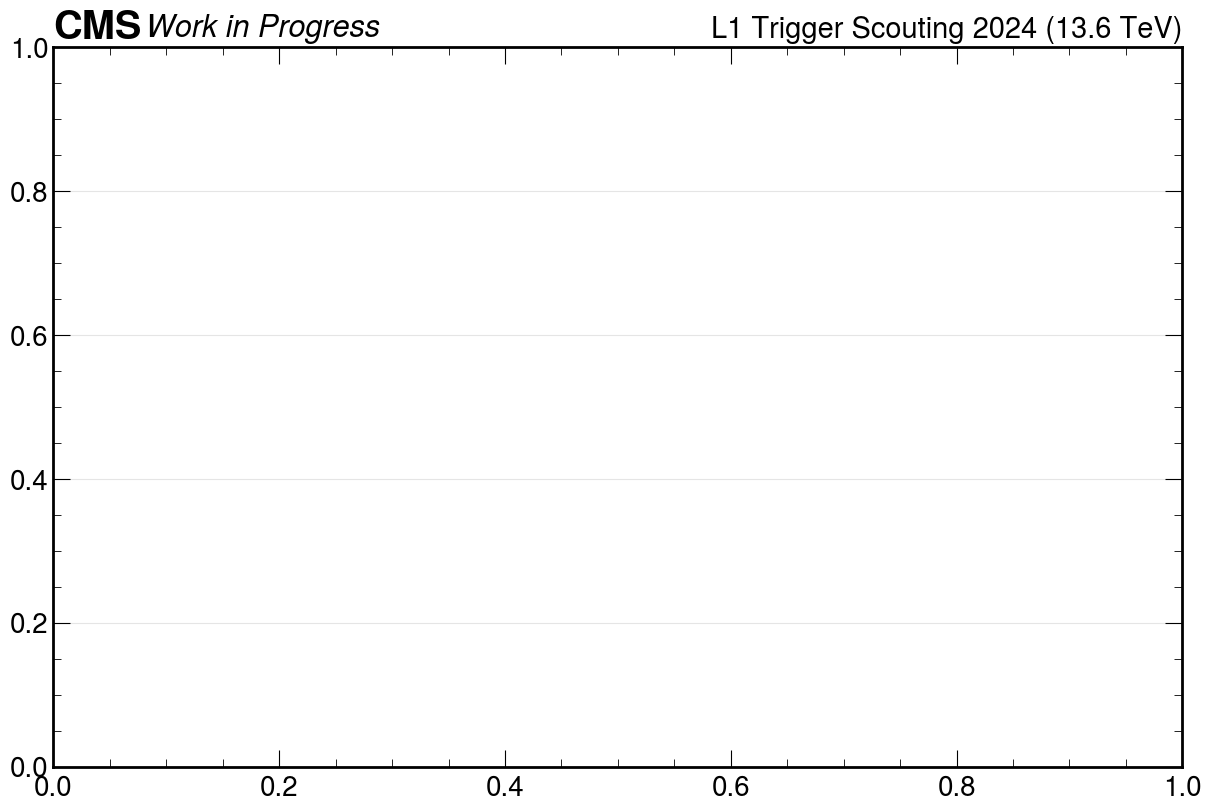

In [12]:
fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize=FONTSIZE, label="Work in Progress", rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")

#hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax,  norm = LogNorm())


plt.scatter(bins, BMTFMatchingEfficiecy)
plt.scatter(bins, GMTMatchingEfficiecy)


ax.set_xlabel(r'Pt [GeV/c]')
ax.set_ylabel('Matching Efficiecy (%)')
ax.grid(False)

ax.tick_params(axis='both', which='both', length=0, labelsize = FONTSIZE - 5)

plt.show()

# Grafici

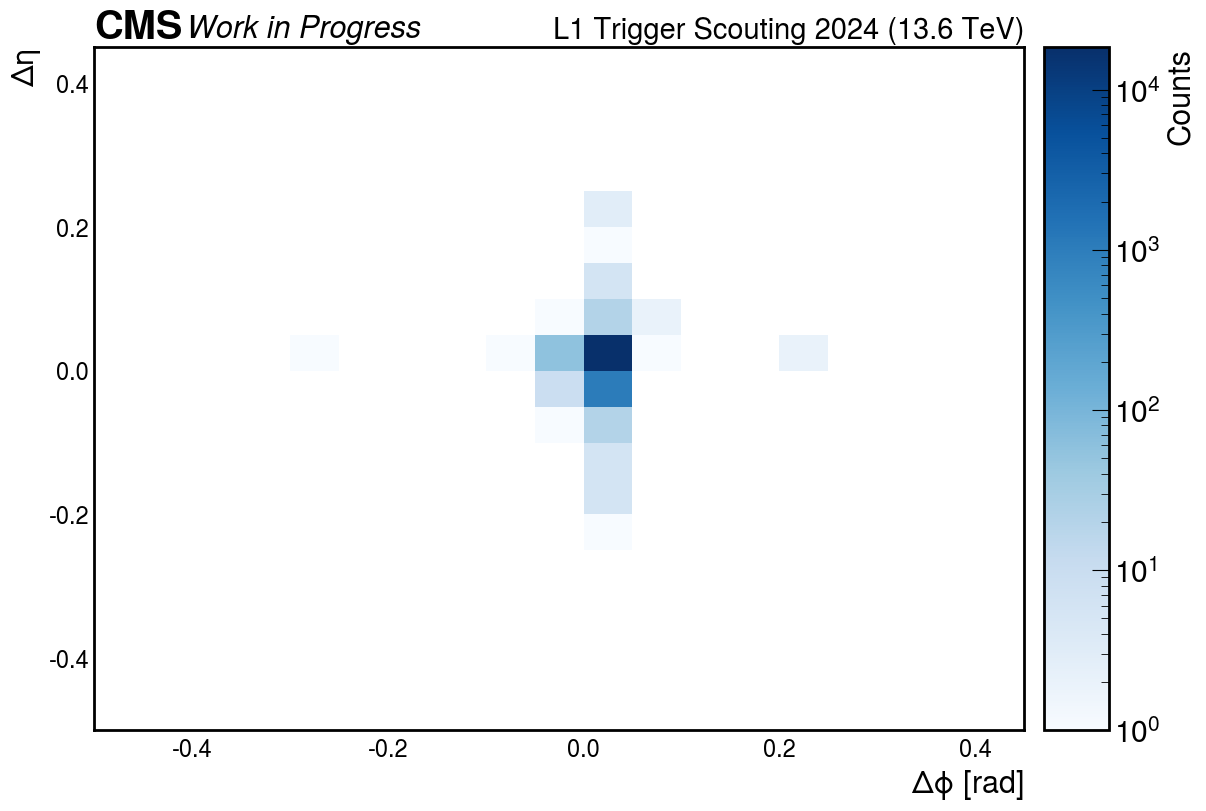

In [10]:
DeltaPhi_BMTF = MuonsProperties.DeltaPhiBMTF
DeltaEta_BMTF = MuonsProperties.DeltaEtaBMTF

a = 0.5
DeltaPhiRange = np.arange(-a, a, 0.05)
DeltaEtaRange = np.arange(-a, a, 0.05)

hist2d = hist.Hist(
    hist.axis.Variable(DeltaPhiRange, name='Phi'),
    hist.axis.Variable(DeltaEtaRange, name='Eta')

)
hist2d.fill(Phi=ak.flatten(DeltaPhi_BMTF), Eta=ak.flatten(DeltaEta_BMTF))

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize=FONTSIZE, label="Work in Progress", rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")

hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax,  norm = LogNorm())

cbar = ax.collections[0].colorbar
cbar.set_label('Counts', fontsize=FONTSIZE)

ax.set_xlabel(r'$\Delta \phi$ [rad]')
ax.set_ylabel(r'$\Delta \eta$')
ax.grid(False)

ax.tick_params(axis='both', which='both', length=0, labelsize = FONTSIZE - 5)


'''plt.savefig("../Immagini/BMTFPhiEta.pdf")
plt.savefig("../Immagini/ImmaginiPNG/BMTFPhiEta.png")'''

plt.show()

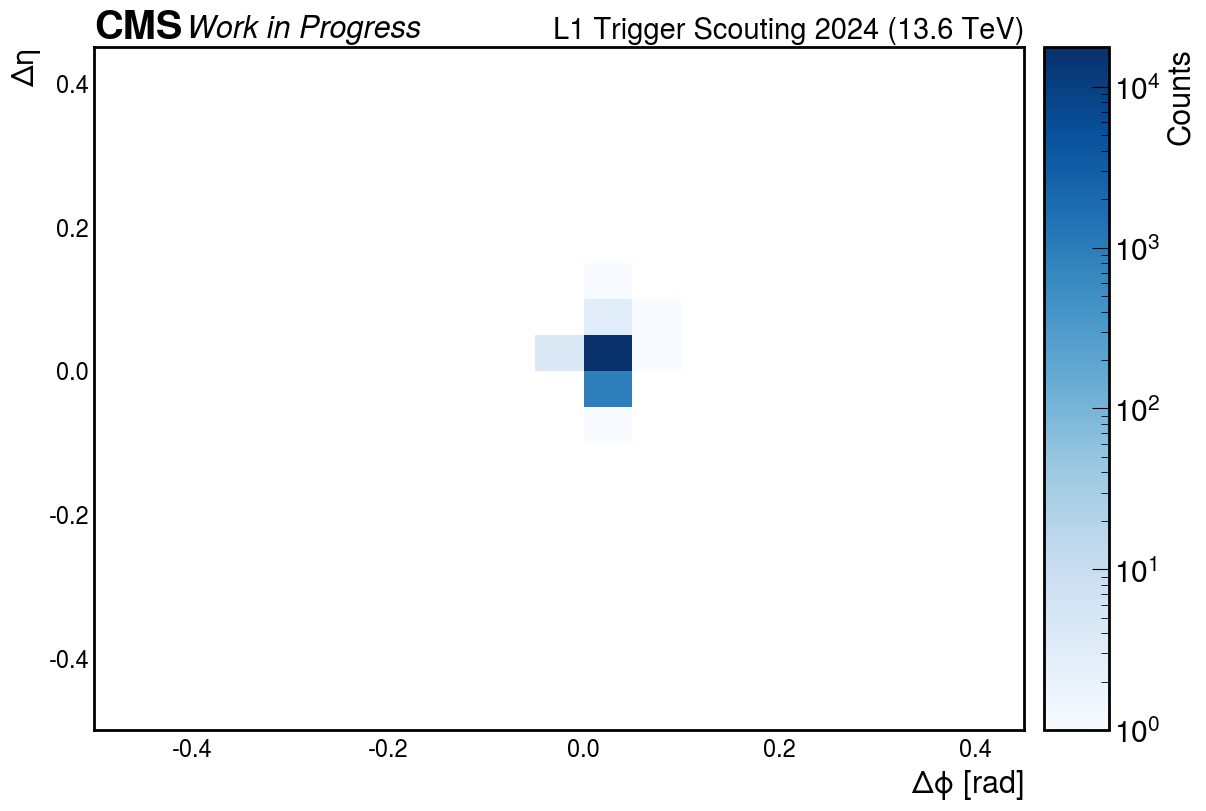

In [11]:
DeltaPhi_GMT = MuonsProperties.DeltaPhiGMT
DeltaEta_GMT = MuonsProperties.DeltaEtaGMT

a = 0.5
DeltaPhiRange = np.arange(-a, a, 0.05)
DeltaEtaRange = np.arange(-a, a, 0.05)

hist2d = hist.Hist(
    hist.axis.Variable(DeltaPhiRange, name='Phi'),
    hist.axis.Variable(DeltaEtaRange, name='Eta')

)
hist2d.fill(Phi=ak.flatten(DeltaPhi_GMT), Eta=ak.flatten(DeltaEta_GMT))

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize=FONTSIZE, label="Work in Progress", rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")

hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax,  norm = LogNorm())

cbar = ax.collections[0].colorbar
cbar.set_label('Counts', fontsize=FONTSIZE)

ax.set_xlabel(r'$\Delta \phi$ [rad]')
ax.set_ylabel(r'$\Delta \eta$')
ax.grid(False)

ax.tick_params(axis='both', which='both', length=0, labelsize = FONTSIZE - 5)


plt.savefig("../Immagini/GMTPhiEta.pdf")
plt.savefig("../Immagini/ImmaginiPNG/GMTPhiEta.png")

plt.show()

# Matching Efficiency 

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/var/folders/73/kb390p311j3ctnbn_v15y42w0000gn/T/ipykernel_10560/2398136408.py:13: SyntaxWarning: invalid escape sequence '\D'
  '''ax.set_xlabel(r'$\Delta \phi$ [rad]')


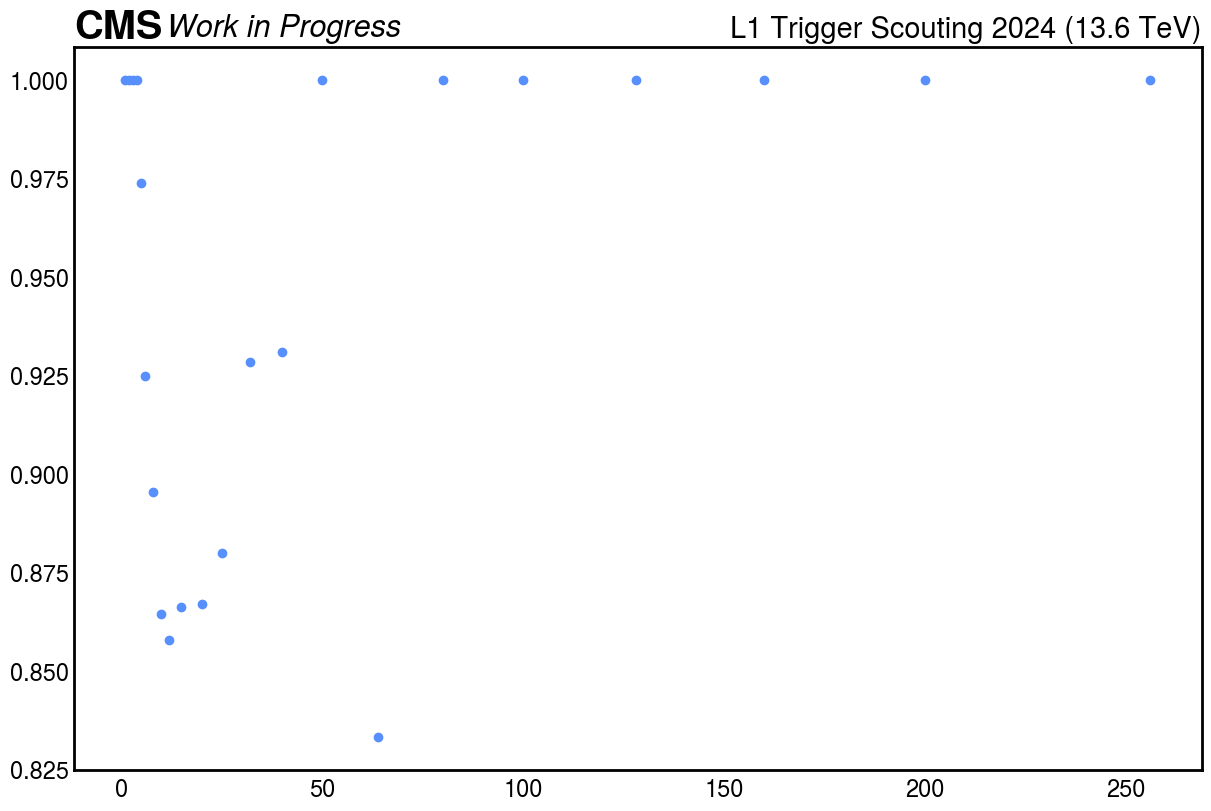

In [96]:
fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize=FONTSIZE, label="Work in Progress", rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")

#hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax,  norm = LogNorm())


plt.scatter(bins, MatchingEfficiecy)


'''ax.set_xlabel(r'$\Delta \phi$ [rad]')
ax.set_ylabel(r'$\Delta \eta$')'''
ax.grid(False)

ax.tick_params(axis='both', which='both', length=0, labelsize = FONTSIZE - 5)

plt.show()